**OBJECTIVE: Analyse results of latest tests with varying threshold**

In [165]:
import numpy as np
import pandas as pd
import igraph as ig

from modSAR.network_algorithms import ModSAR
from modSAR.dataset import QSARDatasetIO
from scripts.validation import DataSplit

from sklearn.externals import joblib

from plotnine import *
%matplotlib inline

dataset_nypr1 = QSARDatasetIO.load(dataset_name='NYPR1', filepath='/mnt/data/NYPR1.xlsx')

Starting CDKBridge


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Data Input

In [3]:
NYPR1_results = pd.concat([pd.read_excel('/mnt/data/results/NYPR1/results_NYPR1_split%02d_alg_modsar.xlsx' % i) 
                           for i in range(1, 5+1)])

In [42]:
NYPR1_models = [joblib.load('/mnt/data/results/NYPR1/NYPR1_split%02d_alg_modsar.joblib' % i) 
                           for i in range(1, 5+1)]

In [24]:
NYPR1_results.head()

,splitStrategy,splitNumber,dataset,datasetVersion,fold,algorithm,algorithm_version,internal,no_modules,no_classes,threshold,train_mae,test_mae,train_rmse,test_rmse,fit_time,beta,lambda
0,1,1,NYPR1,default,1,modSAR,v0.1,True,40,60,0.24,0.105930,0.603444,0.356704,0.925563,51.595313,0.03,0.005
1,1,1,NYPR1,default,1,modSAR,v0.1,True,40,65,0.24,0.364761,0.794514,0.681562,1.160931,21.082392,0.03,0.050
2,1,1,NYPR1,default,1,modSAR,v0.1,True,40,49,0.24,0.550385,0.651250,0.909222,0.987716,8.814755,0.03,0.100
3,1,1,NYPR1,default,2,modSAR,v0.1,True,39,70,0.24,0.119399,0.862748,0.354709,1.399845,67.931351,0.03,0.005
4,1,1,NYPR1,default,2,modSAR,v0.1,True,39,74,0.24,0.326296,0.595404,0.601451,0.939482,59.158343,0.03,0.050


# Analysis

## What was the threshold in each data split?

In [37]:
def get_threshold(data):
    return pd.Series({'threshold': data['threshold'].unique()[0]})
    

threshold_agg = NYPR1_results.groupby(['algorithm', 'dataset', 'splitNumber']).apply(get_threshold)
threshold_agg

threshold
algorithm dataset splitNumber           
modSAR    NYPR1   1                 0.24
                  2                 0.24
                  3                 0.28
                  4                 0.25
                  5                 0.24

Optimal network thresholds varied in the interval $t_\alpha^* \in [0.24, 0.28]$ with a mean of $\bar{t_\alpha^*} = 0.25$ and $median(t_\alpha^*) = 0.24$. **These values were close to previous results where threshold value was set at $t_\alpha^* = 0.24$.**

In [38]:
threshold_agg.describe()

,threshold
count,5.000000
mean,0.250000
std,0.017321
min,0.240000
25%,0.240000
50%,0.240000
75%,0.250000
max,0.280000


## What were the network statistics in each data split?

In the first version of the paper, we were using all samples to find the optimal threshold and compute statistics. 
Now, because we are varying the optimal threshold, I decided to show properties of the graph that represents the best model in each data split.

These graphs were the ones actually used to predict new samples in the internal and external test samples.

In [92]:
def get_network_stats(i, g):
    modules = pd.Series(g.vs['louvain']).value_counts()
    return pd.DataFrame({'data_split': i + 1,
                         'nodes': len(g.vs),
                         'density': g.density(),
                         'threshold': g['threshold'],
                         'ACC': g['globalClusteringCoefficient'],
                         'number_main_modules': len(modules[modules != 1]),
                         'number_singletons': len(modules[modules == 1]),
                         'average_degree': np.mean(g.degree()),
                         'average_path_length': g.average_path_length(),
                         'degree_assortativity': g.assortativity_degree()},
                        index=[0])

network_stats = pd.concat([get_network_stats(i, NYPR1_models[i].instance_graph) for i in range(5)])
network_stats

,data_split,nodes,density,threshold,ACC,number_main_modules,number_singletons,average_degree,average_path_length,degree_assortativity
0,1,247,0.065633,0.24,0.646168,14,30,16.145749,4.488462,0.579640
0,2,248,0.063700,0.24,0.638577,11,23,15.733871,4.146621,0.622695
0,3,248,0.051228,0.28,0.625112,20,57,12.653226,1.641565,0.787721
0,4,247,0.061848,0.25,0.641258,11,27,15.214575,4.510657,0.630538
0,5,247,0.065271,0.24,0.647363,12,23,16.056680,4.945100,0.721099


Properties `edge density` and `ACC` have remained roughly the same, suggesting that the overall connectivity and interconnectedness (clustering coefficient) of the network have not changed much.

The change in the other properties can be explained by the number of samples used to compute the statistics. While we were making full use of the data to compute the optimal threshold and network statistics, here I am just showing the best graphs as trained by cross-validation and only on internal training samples.

Because of the change in number of samples represented, we have fewer singletons. This means we do not have as many nodes with $degree_i = 0$ and as a consequence the average degree had a small decrease and the average path length has increased. 

**Average network statistics accross all 5 data splits:**

In [99]:
network_stats.drop(columns=['data_split']).apply(lambda x: x.describe().transpose())

,nodes,density,threshold,ACC,number_main_modules,number_singletons,average_degree,average_path_length,degree_assortativity
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,247.400000,0.061536,0.250000,0.639696,13.600000,32.000000,15.160820,3.946481,0.668338
std,0.547723,0.005954,0.017321,0.008903,3.781534,14.282857,1.448444,1.319277,0.084284
min,247.000000,0.051228,0.240000,0.625112,11.000000,23.000000,12.653226,1.641565,0.579640
25%,247.000000,0.061848,0.240000,0.638577,11.000000,23.000000,15.214575,4.146621,0.622695
50%,247.000000,0.063700,0.240000,0.641258,12.000000,27.000000,15.733871,4.488462,0.630538
75%,248.000000,0.065271,0.250000,0.646168,14.000000,30.000000,16.056680,4.510657,0.721099
max,248.000000,0.065633,0.280000,0.647363,20.000000,57.000000,16.145749,4.945100,0.787721


# How did the models fit the training and test samples?

Internal train and test values are a bit larger than before. Previous results showed an internal training MAE on average $0.24 \pm 0.11$ and an internal test MAE $\approx 0.60$

## Internal training samples

### MAE

In [147]:
def get_validation_stats(data, metrics=['train_mae']):
    threshold = get_threshold(data)
    internal = data[data['internal']]

    training =  internal[metrics].describe().drop(index=['count']).transpose()
    
    return training
    

group_keys = ['algorithm', 'dataset', 'splitNumber']
NYPR1_results.groupby(group_keys).apply(get_validation_stats)\
    .reset_index().merge(threshold_agg.reset_index()).rename(columns={'level_3': 'metric'})\
    .set_index(['algorithm', 'dataset', 'metric', 'splitNumber', 'threshold'])

mean    ...          max
algorithm dataset metric    splitNumber threshold              ...             
modSAR    NYPR1   train_mae 1           0.24       0.328793    ...     0.604251
                            2           0.24       0.303831    ...     0.616778
                            3           0.28       0.212650    ...     0.325121
                            4           0.25       0.306129    ...     0.560344
                            5           0.24       0.307712    ...     0.548669

[5 rows x 7 columns]

### RMSE

In [148]:
NYPR1_results.groupby(group_keys).apply(lambda x: get_validation_stats(x, ['train_rmse']))\
    .reset_index().merge(threshold_agg.reset_index()).rename(columns={'level_3': 'metric'})\
    .set_index(['algorithm', 'dataset', 'metric', 'splitNumber', 'threshold'])

mean    ...          max
algorithm dataset metric     splitNumber threshold              ...             
modSAR    NYPR1   train_rmse 1           0.24       0.623859    ...     1.011922
                             2           0.24       0.566258    ...     0.997145
                             3           0.28       0.468341    ...     0.714417
                             4           0.25       0.585008    ...     0.942749
                             5           0.24       0.580832    ...     0.917372

[5 rows x 7 columns]

## Internal test samples

### MAE

In [149]:
NYPR1_results.groupby(group_keys).apply(lambda x: get_validation_stats(x, ['test_mae']))\
    .reset_index().merge(threshold_agg.reset_index()).rename(columns={'level_3': 'metric'})\
    .set_index(['algorithm', 'dataset', 'metric', 'splitNumber', 'threshold'])

mean    ...          max
algorithm dataset metric   splitNumber threshold              ...             
modSAR    NYPR1   test_mae 1           0.24       0.755370    ...     1.541923
                           2           0.24       0.715347    ...     1.338009
                           3           0.28       0.730041    ...     0.974444
                           4           0.25       0.751381    ...     1.507573
                           5           0.24       0.711096    ...     1.467112

[5 rows x 7 columns]

### RMSE

In [157]:
NYPR1_results.groupby(group_keys).apply(lambda x: get_validation_stats(x, ['test_rmse']))\
    .reset_index().merge(threshold_agg.reset_index()).rename(columns={'level_3': 'metric'})\
    .set_index(['algorithm', 'dataset', 'metric', 'splitNumber', 'threshold'])

mean    ...          max
algorithm dataset metric    splitNumber threshold              ...             
modSAR    NYPR1   test_rmse 1           0.24       1.116883    ...     2.344513
                            2           0.24       1.065044    ...     2.074222
                            3           0.28       1.044967    ...     1.330899
                            4           0.25       1.122042    ...     2.283681
                            5           0.24       1.071002    ...     2.177607

[5 rows x 7 columns]

## External test sample

The table below only shows results at each data split and is not comparable to Figure 5a.

The results show an average $MAE \approx 0.60$ which is good and is close to what we generally got on the previous results for this dataset. A reproduction of Figure 5 will allow for a better comparison.

In [155]:
NYPR1_results.query('internal == False')[group_keys + ['test_mae', 'test_rmse']]

,algorithm,dataset,splitNumber,test_mae,test_rmse
300,modSAR,NYPR1,1,0.626806,0.886299
300,modSAR,NYPR1,2,0.575964,0.899732
3,modSAR,NYPR1,3,0.512777,0.771867
300,modSAR,NYPR1,4,0.517462,0.793021
300,modSAR,NYPR1,5,0.724776,1.076292


In [166]:
data_split = DataSplit(dataset_nypr1, filename='/mnt/data/NYPR1_splits.xlsx')

In [183]:
def get_external_predictions(split_number):
    idx = data_split.get_id_external_samples(split_number)
    
    X = data_split.qsar_dataset.X.loc[idx]
    X_smiles = data_split.qsar_dataset.X_smiles.loc[idx]
    y = data_split.get_external_Y(split_number)
    
    alg = NYPR1_models[(split_number - 1)]
    y_pred = pd.Series(alg.predict(X, X_smiles))
    y_pred.index = y.index.values
    y_pred.name = 'predicted'
    
    split_number = pd.DataFrame({'split_number': [1] * len(y_pred)}, index=y.index.values)
    
    return pd.concat([split_number, y, y_pred], axis=1)
    
# get_external_predictions(1)
external_predictions = pd.concat([get_external_predictions(i) for i in range(1, 5+1)])

Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.


In [221]:
external_predictions['absolute_error'] =\
    abs(external_predictions['pchembl_value'] - external_predictions['predicted'])

def get_absolute_error_stats(data):
    stats = data['absolute_error'].describe()
    return pd.Series({'median': stats['50%'],
                      'Q1': stats['25%'],
                      'Q3': stats['75%']})
    
external_abs_stats = external_predictions['absolute_error'].describe().to_frame().transpose()

In [237]:
external_abs_stats['label'] = \
    "median = %.2f\nQ1 = %.2f\nQ3 = %.2f" % (external_abs_stats['50%'], 
                                                       external_abs_stats['25%'], 
                                                       external_abs_stats['75%'])
external_abs_stats

,count,mean,std,min,25%,50%,75%,max,label
absolute_error,440.0,0.591557,0.668354,0.0,0.139728,0.335,0.7725,3.99,median = 0.33\nQ1 = 0.14\nQ3 = 0.77


/opt/conda/lib/python3.6/site-packages/plotnine/coords/coord_cartesian.py:31: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  self.limits = Bunch(xlim=xlim, ylim=ylim)
/opt/conda/lib/python3.6/copy.py:274: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  y = func(*args)
/opt/conda/lib/python3.6/site-packages/plotnine/layer.py:520: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/opt/conda/lib/python3.6/site-packages/plotnine/facets/facet.py:151: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  scales = Bunch()
/opt/conda/lib/python3.6/site-packages/plotnine/facets/layout.py:147: MatplotlibDeprecationWarning: The Bunch class w

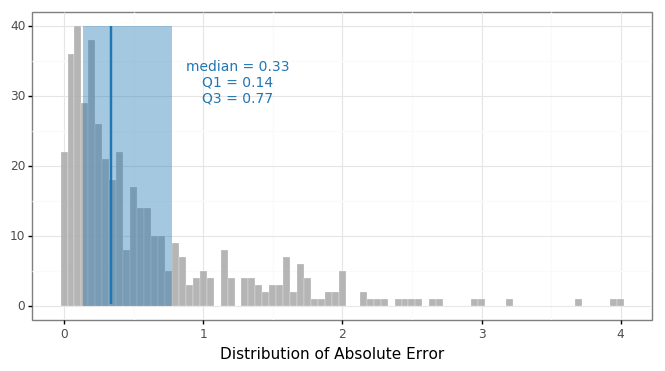

<ggplot: (8754213059753)>

In [241]:
g = (
  ggplot(external_predictions) + 
    geom_histogram(aes(x="absolute_error"), alpha=0.9, color='white', fill='#ADADAD', 
                   binwidth = 0.05, size=0.1) + 
    geom_rect(data=external_abs_stats, mapping=aes(xmin='25%', xmax='75%', ymin=0, ymax=40), 
              alpha=0.4, fill='#1f77b4') + 
    geom_segment(data=external_abs_stats, mapping=aes(y=40, yend='50%', x='50%', xend='50%'), 
                 color='#1f77b4', size=1) +
    geom_text(data=external_abs_stats, mapping=aes(label='label'), 
              color='#1f77b4', x=1.25, y=40*0.8, size=10) + 
    theme_bw() + xlab("Distribution of Absolute Error") + ylab("") +
    theme(figure_size=(8, 4))
)
g